In [55]:
import numpy as np
from qiskit.opflow import (
    Z,
    X,
    Y,
    I,
    Plus,
    Minus,
    Zero, One,
    CX, S, H, T, CZ, Swap,
    TensoredOp
)
from qiskit import QuantumCircuit
from qiskit.quantum_info.operators import Operator, Pauli
from qiskit.circuit.library import LinearFunction
from qiskit import transpile
I0 = (I + Z) / 2
I1 = (I - Z) / 2

# Shift Operator

One important circuit is the one that does the transformation |i> -> |i+1> in the computation basis, aka the shif operator

In [2]:
from typing import Optional, List, Union, Dict, Sequence
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit.parameterexpression import ParameterValueType
from qiskit.circuit.register import Register
from qiskit.circuit.bit import Bit
from qiskit.quantum_info.operators import Operator
import numpy as np


class ShiftOperator(QuantumCircuit):

    def __init__(
        self,
        regs: Union[Register, int, Sequence[Bit]],
        name: Optional[str] = None,
        global_phase: ParameterValueType = 0,
        metadata: Optional[Dict] = None,
        use_mct_ancilla: bool = False
    ):

        self.qreg = QuantumRegister(regs)
        super().__init__(self.qreg)
        

        if not use_mct_ancilla:
            for i in reversed(range(1, self.num_qubits)):
                self.mct(self.qreg[:i], self.qreg[i])
            self.x(self.qreg[0])
        else:
            qreg_shift_ancilla = QuantumRegister(self.num_qubits-3, 'q_shift_ancilla')
            self.add_register(qreg_shift_ancilla)
            for i in reversed(range(1, self.num_qubits)):
                self.mct(self.qreg[:i], self.qreg[i], qreg_shift_ancilla, mode='v-chain')
            self.x(self.qreg[0])
            
s = ShiftOperator(3)
Padj = Operator(s).adjoint()


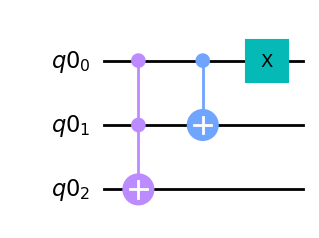

In [3]:
s.draw('mpl')

# Double Shift Operator
The operator that does |i> => |i+2>

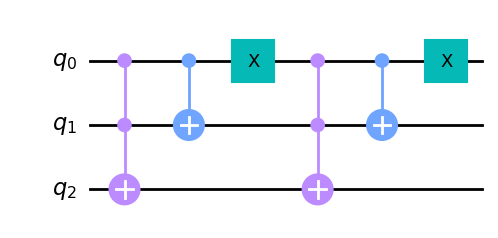

In [6]:
qc = QuantumCircuit(3)
qc.compose(s,inplace=True)
qc.compose(s,inplace=True)
qc.draw('mpl')


In [16]:
P = Operator(qc).data.real
Padj = Operator(qc.inverse()).data.real

# Matrix to decompose

When considering a linear array where only the nearest neighbor interactions are inculded, the matrix of the linear system is:

In [11]:
import numpy as np
A0 = np.array([
       [ 320.,  -64., -384.,    0.,    0.,    0.,   64.,   64.],
       [ -64.,  320.,    0., -384.,    0.,    0.,   64.,   64.],
       [-384.,    0.,  768.,    0., -384.,    0.,    0.,    0.],
       [   0., -384.,    0.,  768.,    0., -384.,    0.,    0.],
       [   0.,    0., -384.,    0.,  768.,    0., -384.,    0.],
       [   0.,    0.,    0., -384.,    0.,  768.,    0., -384.],
       [  64.,   64.,    0.,    0., -384.,    0.,  320.,  -64.],
       [  64.,   64.,    0.,    0.,    0., -384.,  -64.,  320.]])


This matrix can be decomposed using unitaries/permuation matrix as:

In [70]:
I = np.eye(8)
a = 320*I - 384*(P + Padj)

b = np.eye(8)
b[0,0] = b[1,1] = b[-2,-2] = b[-1,-1] = 0
b[0,-1] = b[-1,0] = b[1,-2] = b[-2, 1] = 1

c = np.eye(8)
c[0,0] = c[1,1] = c[-2,-2] = c[-1,-1] = 0
c[0,1] = c[1,0] = c[-2,-1] = c[-1,-2] = 1

d = np.eye(8)
d[0,0] = d[1,1] = d[-2,-2] = d[-1,-1] = 0
d[0,-2] = d[-2,0] = d[1,-1] = d[-1, 1] = 1

A0 - (a + 448*d - 64*c + 64*b)

array([[0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.]])

# Quantum circuit for $b$
The matrix $b$ is given by: 

In [68]:
b

array([[0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.]])

This matrix can be encoded in the following circuit

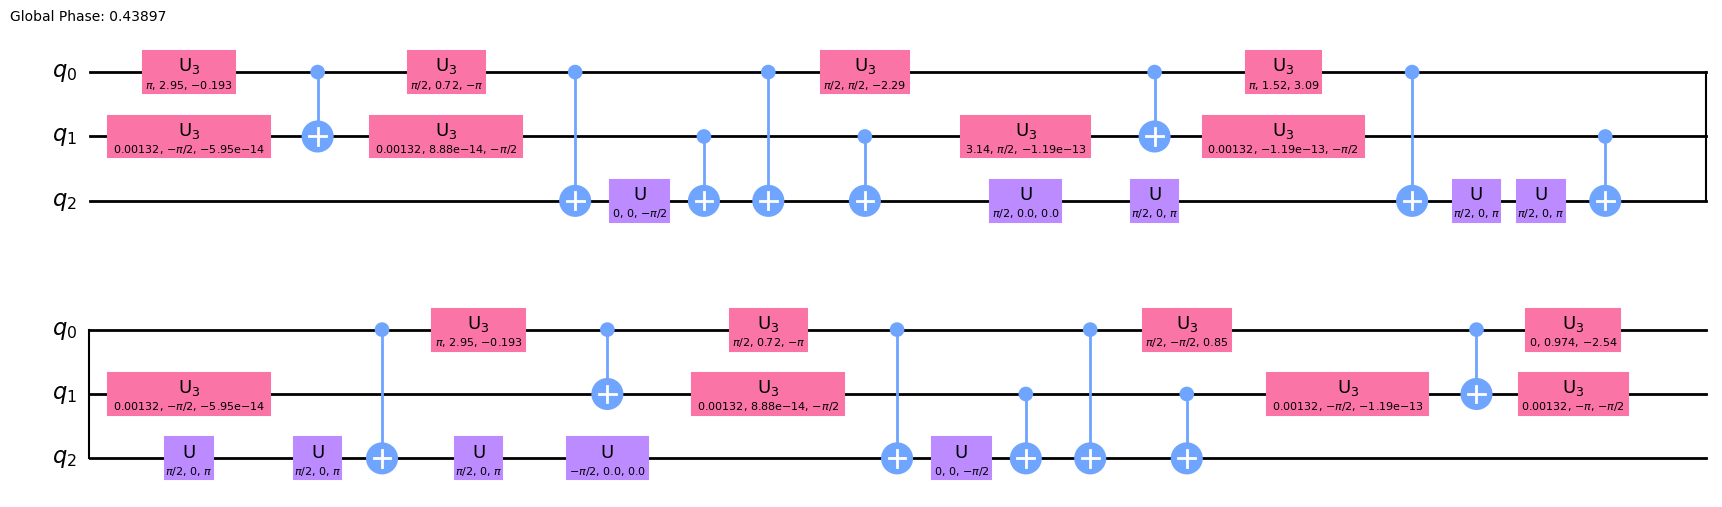

In [74]:
qc_b = QuantumCircuit(3)
qc_b.unitary(b,[0,1,2])
tqc_b = transpile(qc_b)
tqc_b.decompose().draw('mpl')


In [75]:
Operator(qc_b).data.real

array([[0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.]])

# Quantum circuit for $c$
The matrix $c$ is given by 

In [76]:
c

array([[0., 1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1., 0.]])

This matrix can be encoded in the following circuit

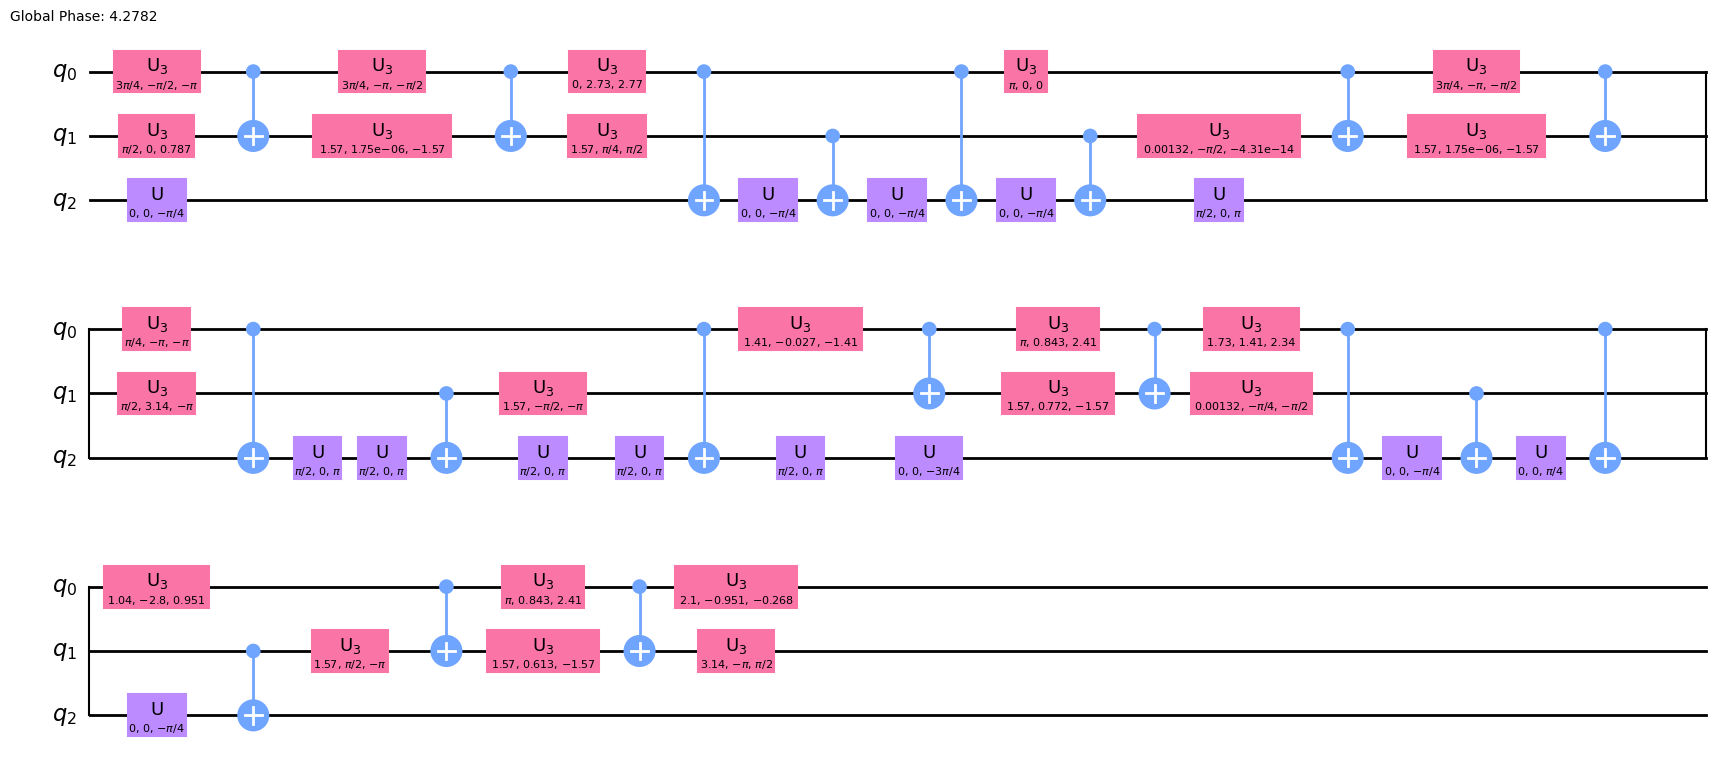

In [77]:
qc_c = QuantumCircuit(3)
qc_c.unitary(c,[0,1,2])
tqc_c = transpile(qc_c)
tqc_c.decompose().draw('mpl')


In [78]:
Operator(qc_c).data.real

array([[0., 1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1., 0.]])

# Quantum circuit for $d$
The matrix $|c|$ is given by: 

In [79]:
d

array([[0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.]])

This matrix can be encoded in the follwoing circuit:

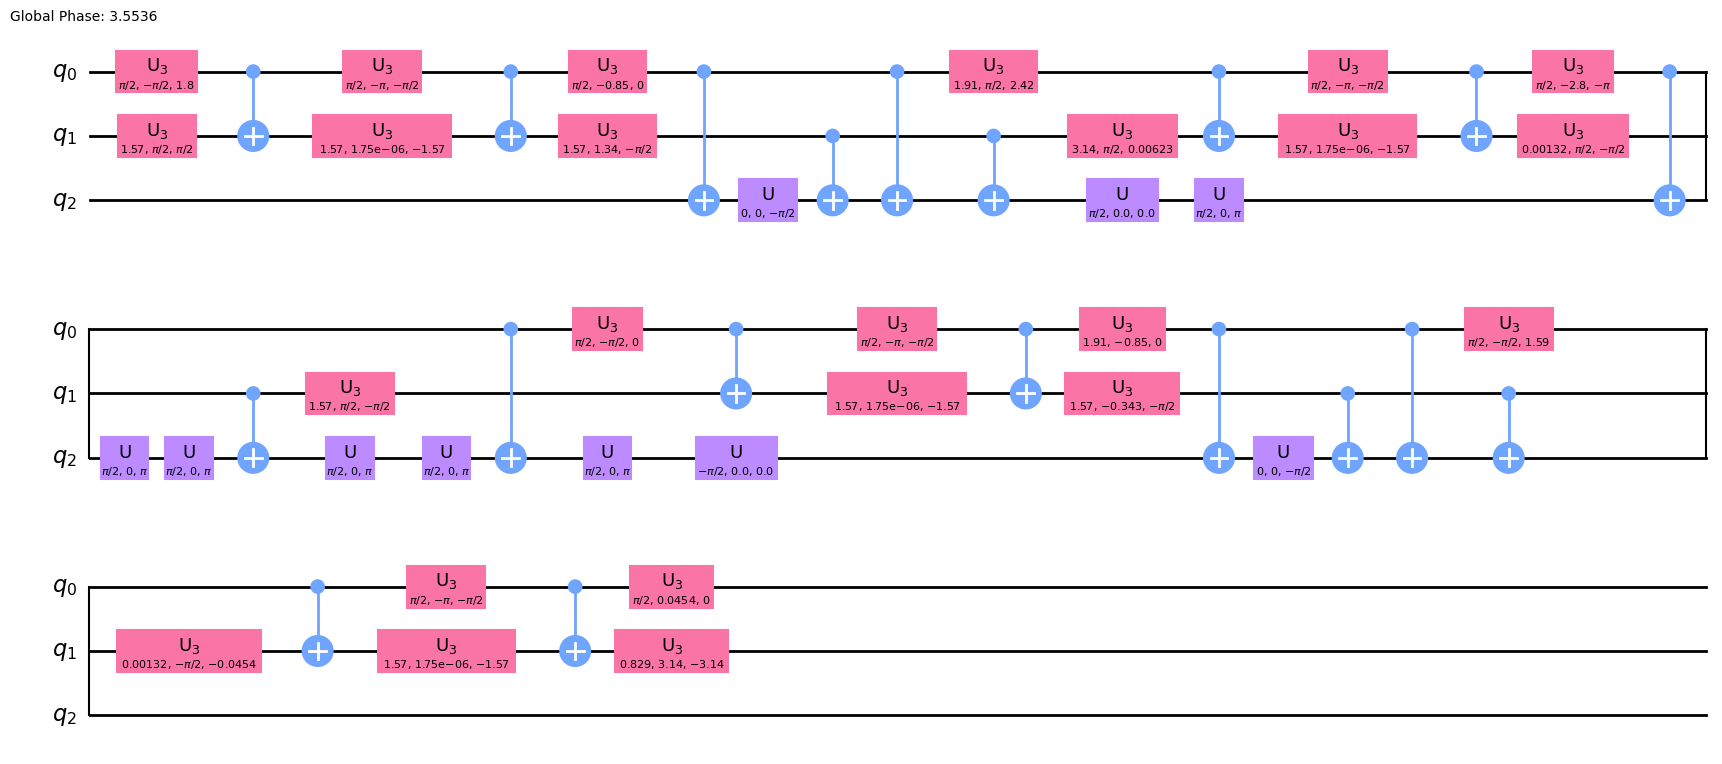

In [80]:
qc_d = QuantumCircuit(3)
qc_d.unitary(d,[0,1,2])
tqc_d = transpile(qc_d)
tqc_d.decompose().draw('mpl')


In [82]:
Operator(qc_d).data.real

array([[0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.]])